In [2]:
import numpy as np, os, sys
sys.path.append("..")

import torch
from torch import nn
from torch.nn import functional as F 

from src.utils.synthetic_seqdata import download_data, load_data, sequence_string_to_one_hot
from src.models.deepbind_cnn import BasicCNN
from src.trainer.trainer import Trainer
from src.utils.datasets import DNASequenceDataset
from sklearn.metrics import roc_auc_score, roc_curve

import matplotlib as mpl 
from matplotlib import pyplot as plt 
%matplotlib inline

In [4]:
# get data 
savedir = "./data"
# _=download_data(savedir)
Xs, Ys = load_data(savedir=savedir)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [33]:
# set up datasets
datasets = {}
for k in Xs:
    datasets[k] = DNASequenceDataset(sequences=Xs[k], labels=Ys[k], alphabet="ACGT")

# set up dataloaders 
batch_size = 32
loaders = {}
for k, dataset in datasets.items():
    if k == 'train':
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    else:
        loaders[k] = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
# set up the model, lossfn, optimizer, trainer 
learning_rate = 0.001
model = BasicCNN(input_size=4, output_size=1, kernel_size=3)
lossfn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
trainer = Trainer(model, lossfn, optimizer)

# fit model
nepochs = 35
history = trainer.fit(loaders['train'], val_loader=loaders['valid'], nepochs=nepochs)

 --- [Epoch   1/35] --- 
loss : 54.4475, val_loss : 52.0800
 --- [Epoch   2/35] --- 
loss : 53.5980, val_loss : 51.5696
 --- [Epoch   3/35] --- 
loss : 53.3233, val_loss : 51.3995
 --- [Epoch   4/35] --- 
loss : 53.3346, val_loss : 51.5241
 --- [Epoch   5/35] --- 
loss : 53.2159, val_loss : 51.3810
 --- [Epoch   6/35] --- 
loss : 53.2301, val_loss : 51.4069
 --- [Epoch   7/35] --- 
loss : 53.2400, val_loss : 51.3207
 --- [Epoch   8/35] --- 
loss : 53.1729, val_loss : 51.3590
 --- [Epoch   9/35] --- 
loss : 53.1968, val_loss : 51.5093
 --- [Epoch  10/35] --- 
loss : 53.2229, val_loss : 51.4825
 --- [Epoch  11/35] --- 
loss : 53.2762, val_loss : 51.4411
 --- [Epoch  12/35] --- 
loss : 53.2654, val_loss : 51.7820
 --- [Epoch  13/35] --- 
loss : 53.3047, val_loss : 51.4523
 --- [Epoch  14/35] --- 
loss : 53.2523, val_loss : 51.4100
 --- [Epoch  15/35] --- 
loss : 53.3225, val_loss : 51.5940
 --- [Epoch  16/35] --- 
loss : 53.3096, val_loss : 51.3530
 --- [Epoch  17/35] --- 
loss : 53.1801,

In [34]:
history

{'loss': [54.44749180258137,
  53.59800926626545,
  53.323302756705786,
  53.33460248659735,
  53.215888698351435,
  53.23013571299374,
  53.23995580194203,
  53.172903735888056,
  53.196810565582695,
  53.222949245749,
  53.27615641241204,
  53.26538416022035,
  53.30465961264693,
  53.25227147803459,
  53.32245527337131,
  53.30960851172878,
  53.1800782626078,
  53.21127122504526,
  53.221692686211576,
  53.187054799571975,
  53.21412662175148,
  53.30757227335891,
  53.29375598855214,
  53.45052313260292,
  53.336512239012,
  53.36948359067037,
  53.412740981742125,
  53.43906806701939,
  53.2439240407726,
  53.389721265122226,
  53.369277292190624,
  53.42802588144938,
  53.5088157566715,
  53.397418631810574,
  53.433295755081524],
 'val_loss': [52.080017362322124,
  51.56959518553719,
  51.39946247282482,
  51.52406895349896,
  51.38100442432222,
  51.4068722800603,
  51.32068945869567,
  51.358976848541744,
  51.50926317487444,
  51.48247546241397,
  51.44109072004046,
  51.781

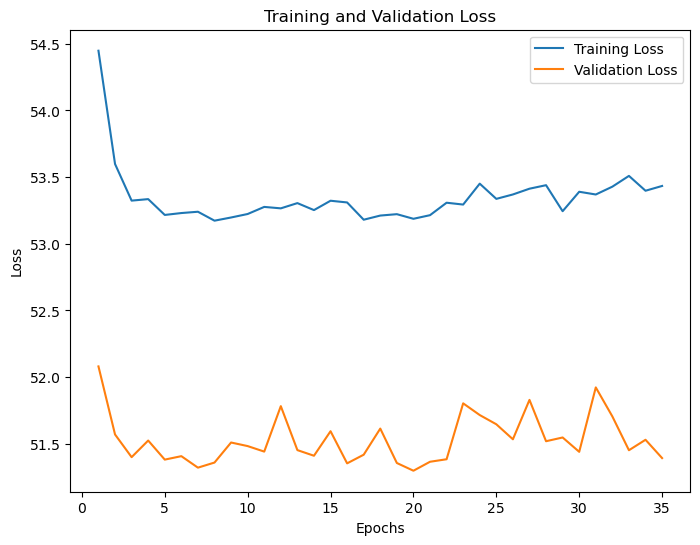

In [35]:
# Calculate AUROC for test predictions
model.eval()
test_scores = []
test_labels = []
with torch.no_grad():
    for inputs, labels in loaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        test_scores.extend(outputs.cpu().squeeze().tolist())
        test_labels.extend(labels.cpu().tolist())

# Plot training/validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(history['loss'])+1), history['loss'], label='Training Loss')
plt.plot(range(1, len(history['val_loss'])+1), history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Test AUROC: 0.8169


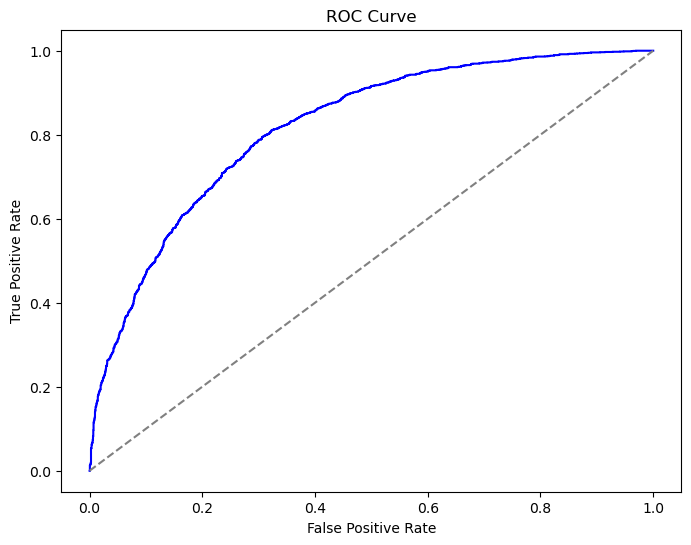

In [36]:
test_auroc = roc_auc_score(test_labels, test_scores)
print(f"Test AUROC: {test_auroc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()